Visualizing Vegetation and Drought Using Python Array Transformations

by Reymond R. Mesuga

As compliance for training entitled Python Programming Fundamentals Course provided by BNHR. The content of this notebook are as follows:

1.) Extracting Data from the Source
2.) 

In [25]:
!uv add rasterio plotly opencv-python geopandas shapely pyproj

Resolved 140 packages in 1.82s
Prepared 4 packages in 3m 37s
Installed 4 packages in 136ms
 + geopandas==1.1.2
 + pyogrio==0.12.1
 + pyproj==3.7.1
 + shapely==2.1.2


In [37]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go

In [38]:
def sentinel_read(sentinel_timestamp):
    sentinel_dir = os.path.join(root_dir, sentinel_timestamp)
    bands = glob.glob(os.path.join(sentinel_dir, '**', '*.jp2'), recursive=True)

    band_arrays = {}
    band_sources = {}

    for band_file in bands:
        fname = os.path.basename(band_file)

        # if fname.endswith('TCI.jp2'):
        #     continue

        band_name = fname.split('_')[-1].replace('.jp2', '')

        src = rasterio.open(band_file)
        arr = src.read(1)

        # initialize lists
        if band_name not in band_arrays:
            band_arrays[band_name] = []
            band_sources[band_name] = []

        band_arrays[band_name].append(arr)
        band_sources[band_name].append(src)

    return sentinel_dir, band_arrays, band_sources


In [39]:
root_dir = './'
sentinel_dir, band_arrays, band_sources = sentinel_read(sentinel_timestamp="data")
band_sources

{'B01': [<open DatasetReader name='./data\2017-01-01\S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE\GRANULE\L1C_T34JEP_A007983_20170101T084543\IMG_DATA\T34JEP_20170101T082332_B01.jp2' mode='r'>,
  <open DatasetReader name='./data\2017-08-19\S2B_MSIL1C_20170804T081559_N0205_R121_T34JEP_20170804T084631.SAFE\GRANULE\L1C_T34JEP_A002149_20170804T084631\IMG_DATA\T34JEP_20170804T081559_B01.jp2' mode='r'>],
 'B02': [<open DatasetReader name='./data\2017-01-01\S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE\GRANULE\L1C_T34JEP_A007983_20170101T084543\IMG_DATA\T34JEP_20170101T082332_B02.jp2' mode='r'>,
  <open DatasetReader name='./data\2017-08-19\S2B_MSIL1C_20170804T081559_N0205_R121_T34JEP_20170804T084631.SAFE\GRANULE\L1C_T34JEP_A002149_20170804T084631\IMG_DATA\T34JEP_20170804T081559_B02.jp2' mode='r'>],
 'B03': [<open DatasetReader name='./data\2017-01-01\S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE\GRANULE\L1C_T34JEP_A007983_20170101T0

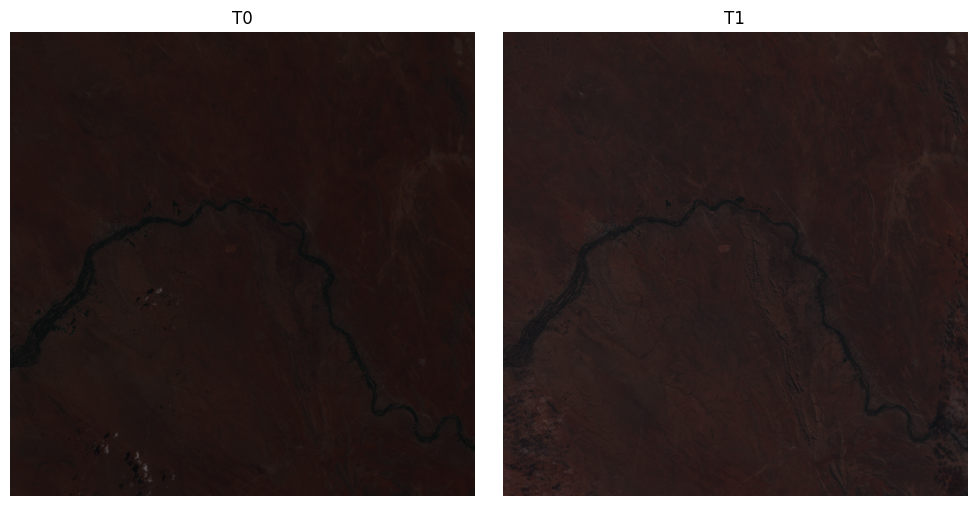

In [18]:
n = len(band_arrays['B04'])  # number of timestamps

fig, axes = plt.subplots(1, n, figsize=(5*n, 5))

for idx, ax in enumerate(axes):

    r = band_arrays['B04'][idx][::5, ::5]
    g = band_arrays['B03'][idx][::5, ::5]
    b = band_arrays['B02'][idx][::5, ::5]

    rgb = np.dstack([r,g,b]).astype(np.float32)
    rgb /= rgb.max()

    ax.imshow(rgb)
    ax.set_title(f"T{idx}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

def visualize_s2_index(band_sources, index_type="NDVI", downsample_factor=20, band_labels=None):
    """
    Memory-safe visualization of Sentinel-2 indices over multiple timestamps.
    
    Parameters:
        band_sources : dict of lists of rasterio DatasetReader per band per timestamp
        index_type : str, one of ['NDVI','SAVI','EVI','GNDVI','NDWI','MNDWI','NDMI','NDBI','IBI','BSI','PVI','MSAVI']
        downsample_factor : int, reduce resolution to save memory
        band_labels : list of str, optional, titles for each timestamp
    """
    n = len(band_sources['B04'])
    
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    if n == 1:
        axes = [axes]
    
    for idx, ax in enumerate(axes):
        # Determine downsampled shape from Red band
        src_red = band_sources['B04'][idx]
        out_shape = (
            src_red.height // downsample_factor,
            src_red.width // downsample_factor
        )
        
        # Read 10m bands
        red = src_red.read(1, out_shape=out_shape).astype(np.float32)
        green = band_sources['B03'][idx].read(1, out_shape=out_shape).astype(np.float32)
        blue = band_sources['B02'][idx].read(1, out_shape=out_shape).astype(np.float32)
        nir = band_sources['B08'][idx].read(1, out_shape=out_shape).astype(np.float32)
        
        # Read 20m bands if needed and resample to match 10m
        swir1 = swir2 = None
        if index_type.upper() in ["NDBI","IBI","BSI","NDMI","MNDWI","MSAVI"]:
            if 'B11' in band_sources:
                swir1 = band_sources['B11'][idx].read(
                    1, out_shape=out_shape, resampling=Resampling.bilinear
                ).astype(np.float32)
            if 'B12' in band_sources:
                swir2 = band_sources['B12'][idx].read(
                    1, out_shape=out_shape, resampling=Resampling.bilinear
                ).astype(np.float32)
        
        # Compute index
        itype = index_type.upper()
        if itype == "NDVI":
            img = (nir - red) / (nir + red + 1e-10)
            cmap = "RdYlGn"
        elif itype == "SAVI":
            L = 0.5
            img = ((nir - red) * (1+L)) / (nir + red + L + 1e-10)
            cmap = "RdYlGn"
        elif itype == "EVI":
            img = 2.5 * (nir - red) / (nir + 6*red - 7.5*blue + 1)
            cmap = "RdYlGn"
        elif itype == "GNDVI":
            img = (nir - green) / (nir + green + 1e-10)
            cmap = "RdYlGn"
        elif itype == "NDWI":
            img = (green - nir) / (green + nir + 1e-10)
            cmap = "Blues"
        elif itype == "MNDWI":
            if swir1 is None:
                raise ValueError("SWIR1 (B11) required for MNDWI")
            img = (green - swir1) / (green + swir1 + 1e-10)
            cmap = "Blues"
        elif itype == "NDMI":
            if swir1 is None:
                raise ValueError("SWIR1 (B11) required for NDMI")
            img = (nir - swir1) / (nir + swir1 + 1e-10)
            cmap = "RdYlGn"
        elif itype == "NDBI":
            if swir1 is None:
                raise ValueError("SWIR1 (B11) required for NDBI")
            img = (swir1 - nir) / (swir1 + nir + 1e-10)
            cmap = "gray"
        elif itype == "IBI":
            if swir1 is None:
                raise ValueError("SWIR1 (B11) required for IBI")
            img = 2 * (swir1 / nir - red / nir) / (swir1 / nir + red / nir + 1e-10)
            cmap = "gray"
        elif itype == "BSI":
            if swir1 is None or swir2 is None:
                raise ValueError("SWIR1 (B11) and SWIR2 (B12) required for BSI")
            img = ((swir1 + red) - (nir + blue)) / ((swir1 + red) + (nir + blue) + 1e-10)
            cmap = "gray"
        elif itype == "PVI":
            ndvi = (nir - red) / (nir + red + 1e-10)
            img = ndvi / np.sqrt(1 + ndvi**2)
            cmap = "RdYlGn"
        elif itype == "MSAVI":
            img = (2 * nir + 1 - np.sqrt((2*nir + 1)**2 - 8*(nir - red))) / 2
            cmap = "RdYlGn"
        else:
            raise ValueError(f"Unknown index_type: {index_type}")
        
        # plot
        ax.imshow(img, cmap=cmap)
        title = f"T{idx}" if band_labels is None else band_labels[idx]
        ax.set_title(title)
        ax.axis('off')
    
    fig.colorbar(ax.images[0], ax=axes, fraction=0.03, pad=0.04, label=itype)
    plt.tight_layout()
    plt.show()

C:\Users\PSA\AppData\Local\Temp\ipykernel_15404\495605767.py:107: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



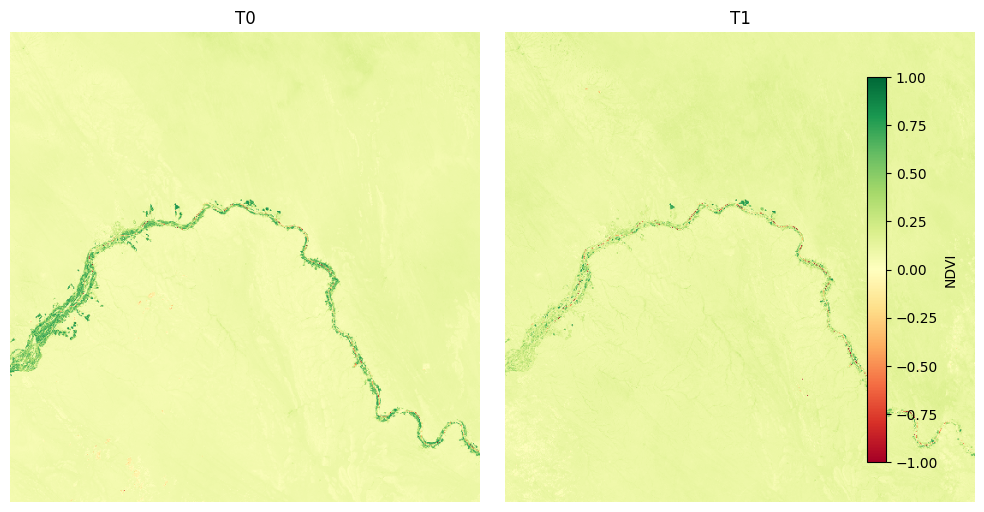

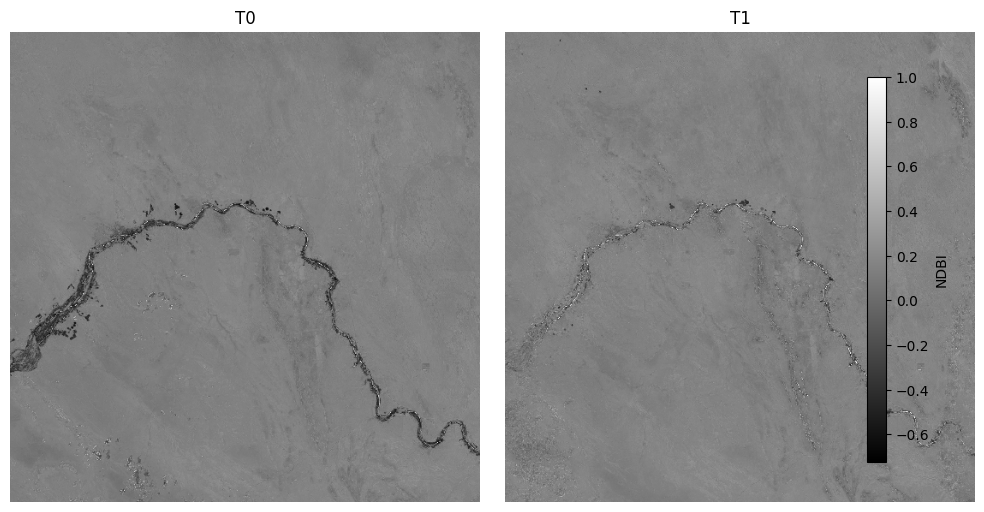

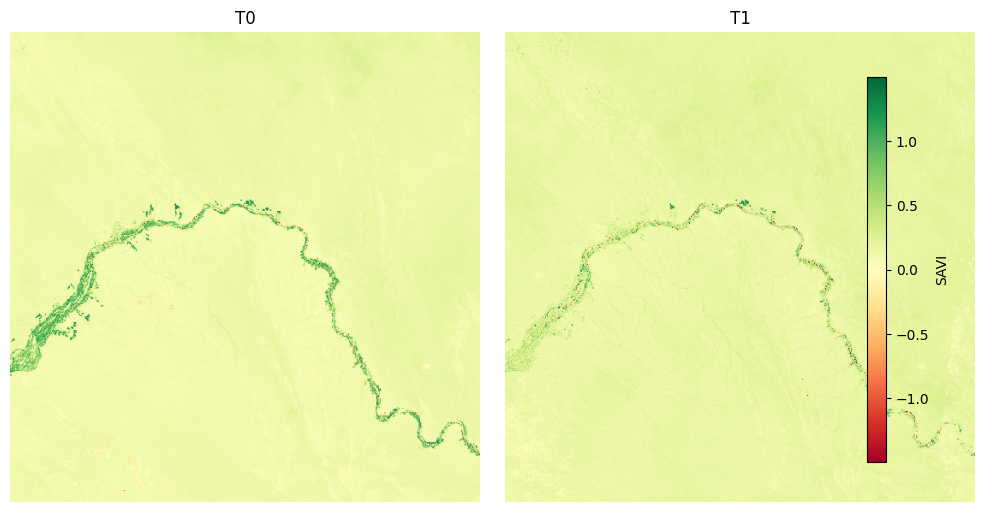

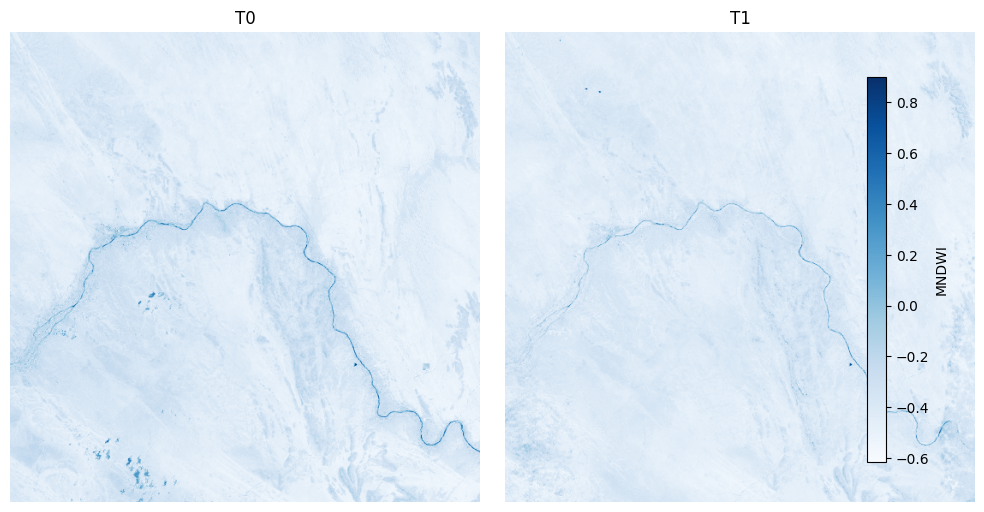

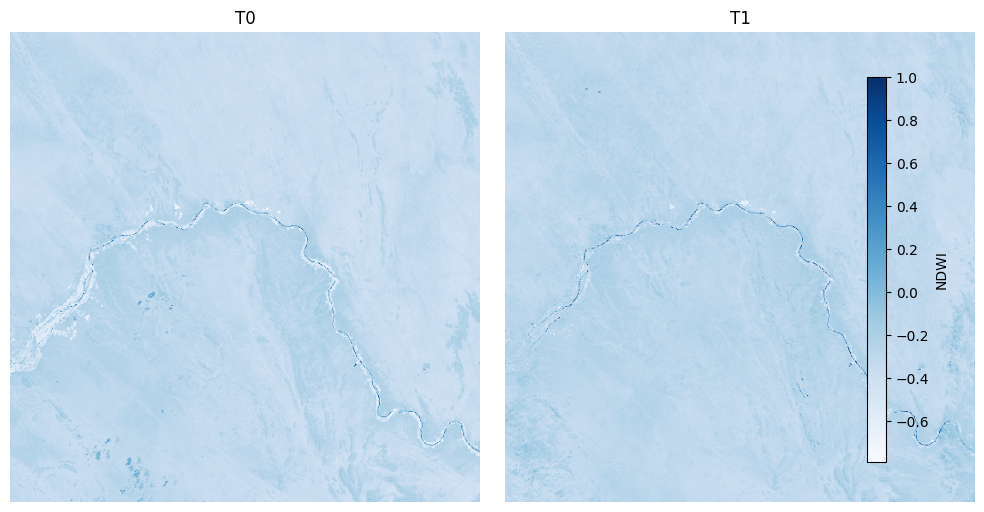

In [43]:
# Visualize NDVI
visualize_s2_index(band_sources, index_type="NDVI", downsample_factor=20)

# Visualize NDBI
visualize_s2_index(band_sources, index_type="NDBI", downsample_factor=20)

# Visualize SAVI
visualize_s2_index(band_sources, index_type="SAVI", downsample_factor=20)

# Visualize MNDWI
visualize_s2_index(band_sources, index_type="MNDWI", downsample_factor=20)

# Visualize MNDWI
visualize_s2_index(band_sources, index_type="NDWI", downsample_factor=20)

In [ ]:
import numpy as np
import plotly.graph_objects as go

def plotly_zoom_rgb_browser(band_arrays, timestamp_idx=0, downsample=20, stretch_pct=(2,98)):
    """
    Interactive zoomable RGB using Plotly, optimized for large Sentinel-2 images.
    Opens in browser if necessary.
    """
    # Extract bands
    r = band_arrays['B04'][timestamp_idx].astype(np.float32)
    g = band_arrays['B03'][timestamp_idx].astype(np.float32)
    b = band_arrays['B02'][timestamp_idx].astype(np.float32)

    # Aggressive downsampling
    if downsample > 1:
        r = r[::downsample, ::downsample]
        g = g[::downsample, ::downsample]
        b = b[::downsample, ::downsample]

    # Percentile stretch
    def stretch(band, lower, upper):
        low = np.percentile(band, lower)
        high = np.percentile(band, upper)
        band = np.clip(band, low, high)
        band = (band - low) / (high - low + 1e-10)
        return band

    r = stretch(r, *stretch_pct)
    g = stretch(g, *stretch_pct)
    b = stretch(b, *stretch_pct)

    # Stack and convert to uint8
    rgb = np.dstack([r, g, b])
    rgb_uint8 = (rgb * 255).astype(np.uint8)

    # Create figure
    fig = go.Figure(go.Image(z=rgb_uint8))
    fig.update_layout(
        title=f"True Color - Timestamp {timestamp_idx}",
        width=800,
        height=800
    )

    # Open in browser (safe for scripts)
    fig.show(renderer="browser")


In [ ]:
# First timestamp
plotly_zoom_rgb_browser(band_arrays, timestamp_idx=0)

# Second timestamp
plotly_zoom_rgb_browser(band_arrays, timestamp_idx=1)


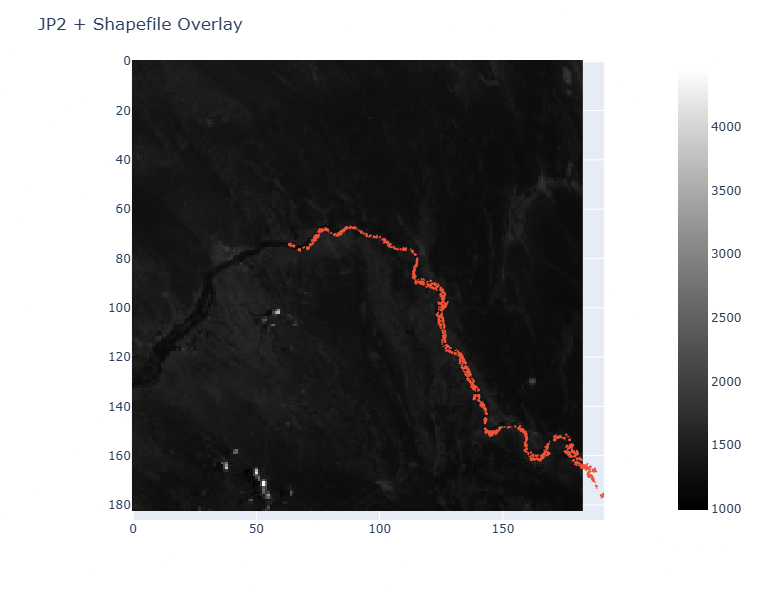

In [41]:
import rasterio
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Polygon, MultiPolygon

# ---------------- CONFIG ----------------
RASTER_PATH = "./data/2017-01-01/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_B01.jp2"
SHAPE_PATH  = "./shapefiles/test/test/test.shp"
DOWNSAMPLE = 10
# ----------------------------------------

# -------- READ RASTER --------
with rasterio.open(RASTER_PATH) as src:
    raster_crs = src.crs
    transform = src.transform

    img = src.read(
        1,
        out_shape=(
            src.height // DOWNSAMPLE,
            src.width // DOWNSAMPLE
        ),
        resampling=rasterio.enums.Resampling.average
    )

# -------- READ SHAPEFILE --------
gdf = gpd.read_file(SHAPE_PATH)

# clean geometries
gdf = gdf[gdf.geometry.notnull()]
gdf = gdf[~gdf.geometry.is_empty]

# reproject
gdf = gdf.to_crs(raster_crs)

# -------- GEO → PIXEL --------
def geo_to_pixel(x, y, transform, scale):
    col, row = ~transform * (x, y)
    return col/scale, row/scale

# -------- EXTRACT SHAPES --------
xs, ys = [], []

for geom in gdf.geometry:

    if geom is None:
        continue

    if geom.geom_type == "Polygon":
        polygons = [geom]

    elif geom.geom_type == "MultiPolygon":
        polygons = geom.geoms

    else:
        continue

    for poly in polygons:
        for x, y in poly.exterior.coords:
            px_val, py_val = geo_to_pixel(
                x, y, transform, DOWNSAMPLE
            )

            xs.append(px_val)
            ys.append(py_val)

        # break between polygons
        xs.append(None)
        ys.append(None)

# -------- PLOT --------
fig = px.imshow(
    img,
    color_continuous_scale="gray"
)

fig.add_trace(
    go.Scatter(
        x=xs,
        y=ys,
        mode="lines",
        line=dict(width=2),
        name="Shapefile"
    )
)

fig.update_layout(
    title="JP2 + Shapefile Overlay",
    width=750,
    height=600
)

fig.show()
